## Group project 

In [34]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
#sns.set_theme(style="darkgrid")
random.seed(10)
import math
import scipy.stats

## Generate the synthetic data set 

In [52]:
bernoulli = random.random()
print(f'Random bernoulli variable is assigned as {bernoulli}')
x = np.random.uniform(0, 10, 1000)
label = np.random.binomial(1, bernoulli, 1000)
noise_a = np.random.normal(0, 1, 1000) 
noise_b = np.random.normal(0, 3, 1000)
d = {'x': x, 'label': label, 'noise_a': noise_a, 'noise_b': noise_b}
df = pd.DataFrame(data=d)
df.loc[df.label == 0, 'y'] = df.x * 3 + 2 + df.noise_a
df.loc[df.label == 1, 'y'] = df.x * 4 + 4 + df.noise_b
df

Random bernoulli variable is assigned as 0.5780913011344704


,x,label,noise_a,noise_b,y
0,2.045004,1,1.408898,2.313349,14.493366
1,3.994646,0,-1.808362,2.413133,12.175577
2,4.986221,1,-0.821638,-3.816587,20.128298
3,4.492704,1,-0.409213,0.692064,22.662879
4,7.655811,1,0.025848,-2.680340,31.942902
...,...,...,...,...,...
995,0.328510,0,0.050834,7.021946,3.036365
996,2.766685,1,-1.198816,-0.932354,14.134387
997,6.494023,0,0.069957,2.088417,21.552025
998,8.979134,0,-0.041950,-3.720198,28.895453


## Plotting the data for a first overview 

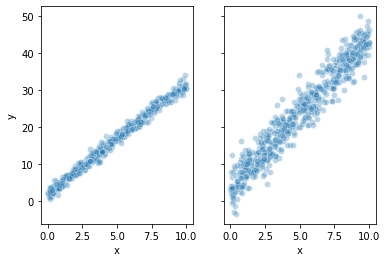

In [53]:
fig, ax =plt.subplots(1,2, sharey=True)
sns.scatterplot(data=df[df.label == 0],x='x', y='y', alpha=0.3,ax=ax[0])
sns.scatterplot(data=df[df.label == 1],x='x', y='y', alpha=0.3,ax=ax[1])


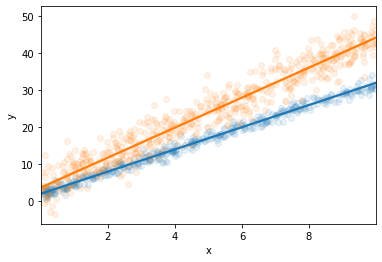

In [54]:
sns.regplot(data=df[df.label == 0],x='x', y='y',scatter_kws={'alpha':0.1})
sns.regplot(data=df[df.label == 1],x='x', y='y',scatter_kws={'alpha':0.1})


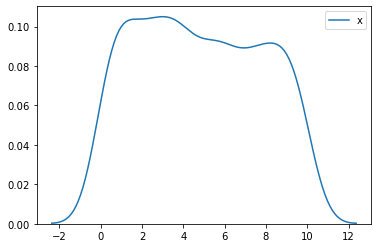

In [55]:
sns.kdeplot(data=df.x)

# Second part: mathematical background 

To Do !

# Third part: Implementation of the EM algorithm 

## Initialization 

In [84]:
# initialization of the parameter
variance_a = random.randint(1, 3) #needs to be >= 0
variance_b = random.randint(1, 3) #needs to be >= 0

beta_a0 = beta_b0 = 0.5
beta_a1 = beta_b1 = 1
prob_a = 0.5
prob_b = 0.5

parameter_list = [beta_a0,beta_a1,variance_a,variance_b,beta_b0,beta_b1,prob_a,prob_b]
parameter_list

[0.5, 1, 1, 3, 0.5, 1, 0.5, 0.5]

## Setting the weights 

In [85]:
w_a_numerator  = prob_a * (1/np.sqrt(2*np.pi*variance_a)) * np.exp((-(1/(2*variance_a)) * (df.y - beta_a0 - beta_a1*df.x)**2))
w_b_numerator = prob_b * (1/np.sqrt(2*np.pi*variance_b)) * np.exp((-(1/(2*variance_b)) * (df.y - beta_b0 - beta_b1*df.x)**2))

w_sum = w_a_numerator + w_b_numerator
print(w_a_numerator[0], w_b_numerator[0],w_sum[0])
w_a = w_a_numerator/w_sum
w_b = w_b_numerator/w_sum

1.991643952553691e-32 5.342731141709328e-12 5.342731141709328e-12


In [86]:
w_data = pd.DataFrame(data = {'w_a':w_a,'w_b':w_b})
w_data.head()

,w_a,w_b
0,3.727764e-21,1.0
1,4.987857e-09,1.0
2,1.593564e-31,1.0
3,1.091189e-45,1.0
4,2.122738e-82,1.0


## Expectation step

In [87]:
##Expectation step
def Estep(parameter_list):
    
    beta_a0=parameter_list[0]
    beta_a1=parameter_list[1]
    variance_a=parameter_list[2]
    variance_b=parameter_list[3]
    beta_b0 = parameter_list[4]
    beta_b1 = parameter_list[5]
    prob_a = parameter_list[6]
    prob_b = parameter_list[7]
    
    #Set the values for the algorithm
    
    w_a_numerator  = prob_a * (1/np.sqrt(2*np.pi*variance_a)) * np.exp((-(1/(2*variance_a)) * (df.y - beta_a0 - beta_a1*df.x)**2))
    w_b_numerator = prob_b * (1/np.sqrt(2*np.pi*variance_b)) * np.exp((-(1/(2*variance_b)) * (df.y - beta_b0 - beta_b1*df.x)**2))

    w_sum = w_a_numerator + w_b_numerator

    w_a = w_a_numerator/w_sum
    w_b = w_b_numerator/w_sum
    
    return(w_a,w_b)


## Maximisation step

In [88]:
## Maximisation step:
def Mstep(w_a, w_b, parameter_list, df):
    
    #parameter_list = [beta_a0,beta_a1,variance_a,variance_b,beta_b0,beta_b1,prob_a,prob_b]
    beta_a0=parameter_list[0]
    beta_a1=parameter_list[1]
    variance_a=parameter_list[2]
    variance_b=parameter_list[3]
    beta_b0 = parameter_list[4]
    beta_b1 = parameter_list[5]
    prob_a = parameter_list[6]
    prob_b = parameter_list[7]
       
    #Update the function following the derived update rules:
    
    #Update the prior beliefs
    prob_a = w_a.sum()/(w_a.sum() +w_b.sum()).sum()
    prob_b = w_b.sum()/(w_a.sum() +w_b.sum()).sum()

    
    #Update the betas for each subgroup
    #Beta_0
    
    beta_a0 = ((df.y - beta_a1*df.x)*w_a).sum()/w_a.sum() 
    beta_b0 = ((df.y - beta_b1*df.x)*w_b).sum()/w_b.sum() 
  
    #New beta formula
    beta_a1 = ((df.y*df.x - beta_a0*df.x)*w_a).sum()/(w_a*df.x**2).sum() 
    beta_b1 = ((df.y*df.x - beta_b0*df.x)*w_b).sum()/(w_b*df.x**2).sum() 
    #print('beta1', beta_a1, beta_b1)
    
    #Update the variance 
    #Define the residuals first
    e_hat_a = df.y - beta_a0-beta_a1*df.x
    e_hat_b = df.y - beta_b0-beta_b1*df.x
    #print('ehat', e_hat_a, e_hat_b)
    
    #Define the variance 

    variance_a = ((e_hat_a**2)*w_a).sum()/w_a.sum()
    variance_b = ((e_hat_b**2)*w_b).sum()/w_b.sum()

    #Store the new parameters in a parameter_list
    parameter_list = [beta_a0,beta_a1,variance_a,variance_b,beta_b0,beta_b1,prob_a,prob_b]
    return parameter_list
    

In [89]:
Mstep(w_a,w_b, parameter_list,df)

[1.9158578485730577,
 1.3388478981563836,
 1.040517460680546,
 64.12785307666765,
 15.976489488720382,
 1.6911442027207422,
 0.02732527703590636,
 0.9726747229640937]

## Defining the average likelihood function

In [90]:
def get_avg_log_likelihood(w_a,w_b,df, parameter_list):
    beta_a0=parameter_list[0]
    beta_a1=parameter_list[1]
    variance_a=parameter_list[2]
    variance_b=parameter_list[3]
    beta_b0 = parameter_list[4]
    beta_b1 = parameter_list[5]
    prob_a = parameter_list[6]
    prob_b = parameter_list[7]   
    
    Q_function_a = -1/2*((w_a*((df.y-beta_a0-beta_a1*df.x)**2-math.log(variance_a))).sum())
    Q_function_b = -1/2*((w_b*((df.y-beta_b0-beta_b1*df.x)**2-math.log(variance_b))).sum())
    
    Q_function = Q_function_a + Q_function_b
    
    return Q_function

In [91]:
def run_em(df, parameter_list):
    avg_loglikelihoods = []
    while True: 
        #Estimation step
        w_a,w_b = Estep(parameter_list) 
        
        #Maximisation step:
        parameter_list = Mstep(w_a,w_b,parameter_list,df) #Update the maximisation step
        
        #Evaluate the loglikelihood function
        avg_loglikelihood = get_avg_log_likelihood(w_a,w_b,df, parameter_list)
        avg_loglikelihoods.append(avg_loglikelihood)
        slope = 1/avg_loglikelihood
        if len(avg_loglikelihoods)>2 and (avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0:
            break
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001: #Define a stopping criterion
            break
    
    return parameter_list, avg_loglikelihoods

In [92]:
test = run_em(df, parameter_list)

In [93]:
test

([2.1017394221391736,
  2.992967600391148,
  1.0132461756480926,
  10.244432251078655,
  3.5776393258276586,
  4.076265821361836,
  0.4213725176564326,
  0.5786274823435674],
 [-29177.853607486028,
  -19414.17560099508,
  -14332.005556547985,
  -11609.248935019938,
  -10083.560688381765,
  -9222.465063277488,
  -8732.783011031508,
  -8435.596286734139,
  -8193.894512614306,
  -7893.952863741939,
  -7476.311334678448,
  -6872.274189978879,
  -6089.636074829609,
  -5265.459229639025,
  -4568.488313167835,
  -4028.811381904491,
  -3616.660079755873,
  -3308.2073512292172,
  -3083.2299418870416,
  -2922.911953046636,
  -2811.025203211562,
  -2733.7415068922364,
  -2680.050079500798,
  -2641.9755139044337,
  -2614.1601751649096,
  -2593.170295561027,
  -2576.85231088061,
  -2563.855319893121,
  -2553.315599776567,
  -2544.661640433403,
  -2537.4982454182154,
  -2531.5390159367266,
  -2526.567239528208,
  -2522.4130465350136,
  -2518.9397617604127,
  -2516.0354375860697,
  -2513.607329277144

## Plotting the iterations 

In [81]:
loglikelihoods = test[1]
iterations = np.arange(0,len(loglikelihoods),1)
data_log = pd.DataFrame(data={'logs': loglikelihoods, 'iterations': iterations})

In [82]:
data_log

,logs,iterations
0,-29486.976921,0
1,-19463.513895,1
2,-14290.090181,2
3,-11562.939424,3
4,-10051.605989,4
...,...,...
88,-2501.403977,88
89,-2501.403801,89
90,-2501.403656,90
91,-2501.403536,91


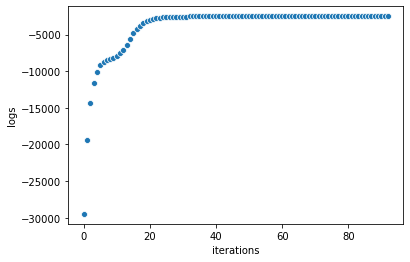

In [83]:
sns.scatterplot(x = 'iterations', y = 'logs', data = data_log)